In [1]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
import numpy as np
import pandas as pd
import seaborn as sns
train = pd.read_csv('../data/spaceship_titanic_train.csv')
test = pd.read_csv('../data/spaceship_titanic_test.csv')

In [2]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from IPython import display

In [3]:
def prepare_data(data, do_1hot=True, X_only = False):
    group_count = lambda id_: id_[:4]
    data['travel_group'] = data['PassengerId'].apply(lambda id_: id_[:4])
    data['travel_group_n'] = data['travel_group'].apply(lambda group: data.loc[data.travel_group == group].shape[0])
    data['travelling_with_n_kids'] = (-1)*(train['Age'] < 18).astype(int)+ data['travel_group'].apply(lambda group: data.loc[(data.travel_group == group) & (data.Age < 18)].shape[0])
    data['cabin_side'] = data.Cabin.apply(lambda cabin: np.nan if str(cabin) == 'nan' else str(cabin)[-1])
    data['cabin_deck'] = data.Cabin.apply(lambda cabin: np.nan if str(cabin) == 'nan' else str(cabin)[0])
    data['cabin_num'] = data.Cabin.apply(lambda cabin: np.nan if str(cabin) == 'nan' else int(str(cabin)[2:-2]))
    
    
    drop_ = ['PassengerId','Name', 'Cabin', 'travel_group']
    if not X_only:
        cat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported', 'cabin_side', 'cabin_deck']
    else:
        cat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'cabin_side', 'cabin_deck']
    num = ['FoodCourt', 'VRDeck', 'Spa', 'Age', 'RoomService', 'ShoppingMall', 'cabin_num']
    one_hot = OneHotEncoder(sparse_output=False, drop='if_binary')
   
    if do_1hot:
        pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        one_hot)
    else:
        pipe = make_pipeline(
        SimpleImputer(strategy='most_frequent'),
        OrdinalEncoder())
    
    transformer = ColumnTransformer([
        ('cat', pipe, cat),
        ('num', SimpleImputer(strategy='mean'), num),
        ('drop_', 'drop', drop_)
    ], remainder='passthrough',
       verbose_feature_names_out=False)

    
    d = transformer.fit_transform(data)
    if do_1hot:
        df = pd.DataFrame(d, columns = transformer.get_feature_names_out(), dtype=float)
    else:
        df = pd.DataFrame(d, columns = transformer.get_feature_names_out())
    return df

In [4]:
train_prep = prepare_data(train, do_1hot = True, X_only=False)
train_X, train_y = train_prep.drop('Transported_True', axis=1), train_prep.Transported_True

In [5]:
xgb_params = {
    #default
    "objective": "binary:logistic",
    "eta": 0.1,
    "verbosity": 0,
    "nthread": 4,
    "random_seed": 1,
    "eval_metric": "error",
    #train-error-mean    0.861325
    #test-error-mean     0.810883
    
    #eta = 0.01 test 0.78, train 80.5
    
    # regularization parameters
    "max_depth": 5,
    "max_leaves": 0,
    "min_child_weight":1,
    "subsample": 0.9,
    "colsample_bytree": 0.9,
    "n_estimators": 10_000
    
    #train-error-mean    0.848240
    #test-error-mean     0.811689
    
#    "tree_method": "hist",    
#    "grow_policy": "lossguide"
#     train-error-mean    0.827677
#     test-error-mean     0.807776
}
xgb_train = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=127)
result = xgb.cv(xgb_params, xgb_train, folds =skf, num_boost_round=10_000, early_stopping_rounds=10, verbose_eval=10)
xgb_params['n_estimators'] = list(result['test-error-mean']).index(min(list(result['test-error-mean'])))
1-result.iloc[-1, [0, 2]]

[0]	train-error:0.24140+0.00109	test-error:0.25020+0.00579
[10]	train-error:0.18981+0.00140	test-error:0.20821+0.00452
[20]	train-error:0.18115+0.00137	test-error:0.20246+0.00477
[30]	train-error:0.17169+0.00144	test-error:0.19591+0.00383
[40]	train-error:0.16620+0.00193	test-error:0.19360+0.00493
[50]	train-error:0.16125+0.00164	test-error:0.19096+0.00499
[60]	train-error:0.15383+0.00171	test-error:0.19038+0.00750
[70]	train-error:0.14960+0.00188	test-error:0.18946+0.00611
[73]	train-error:0.14857+0.00175	test-error:0.18935+0.00643


train-error-mean    0.848240
test-error-mean     0.811689
Name: 64, dtype: float64

In [6]:
xgb_clf = xgb.XGBClassifier(**xgb_params)
xgb_clf.fit(train_X, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='error',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=64, n_jobs=None,
              nthread=4, num_parallel_tree=None, ...)

In [7]:
import shap

explainer = shap.TreeExplainer(xgb_clf, train_X, model_output="probability")

In [8]:
shap.initjs()
shap_values = explainer.shap_values(train_X)
shap.force_plot(explainer.expected_value, shap_values[10,:], train_X.iloc[10,:])

 99%|===================| 8565/8693 [00:11<00:00]       

In [9]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[:10], train_X.iloc[:10,:])

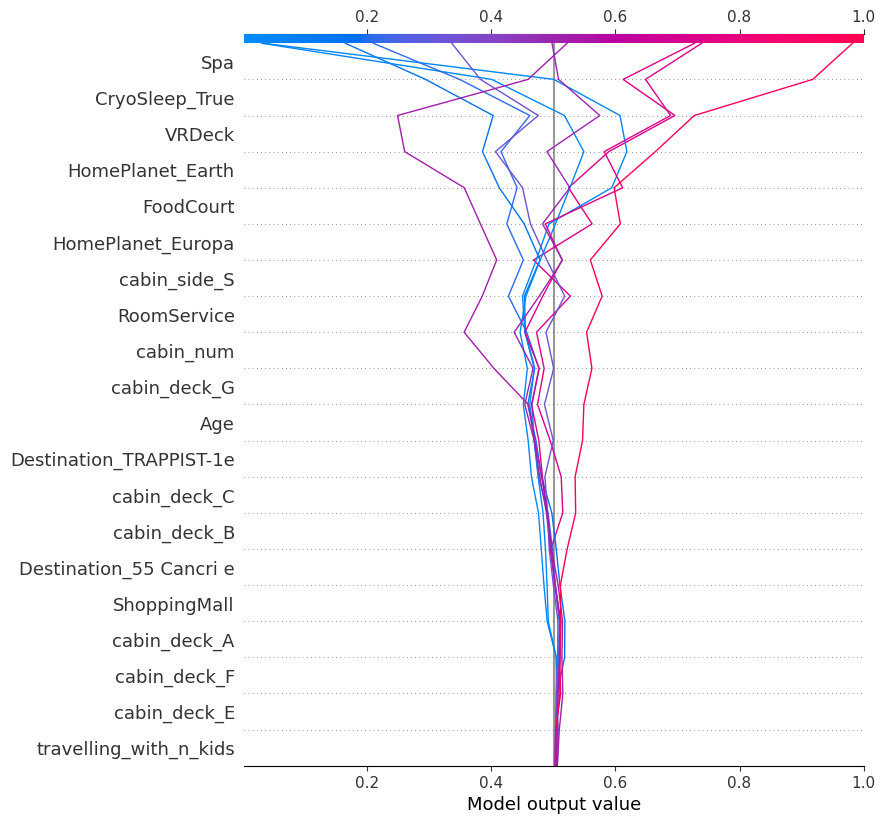

In [11]:
shap.decision_plot(explainer.expected_value, shap_values[:10, :], feature_names=list(train_X.columns))

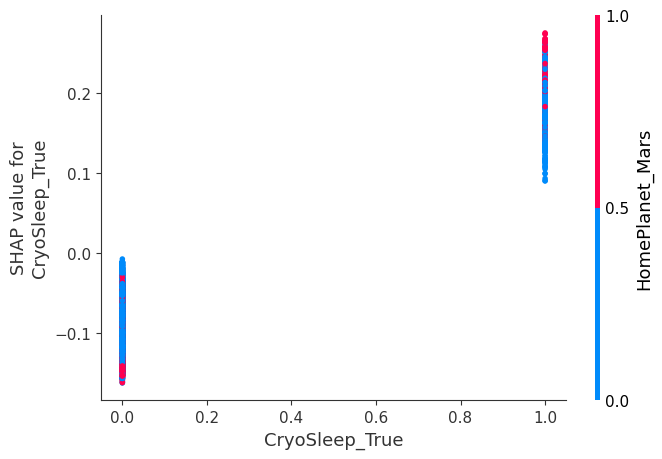

In [14]:
shap.dependence_plot("CryoSleep_True", shap_values, train_X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


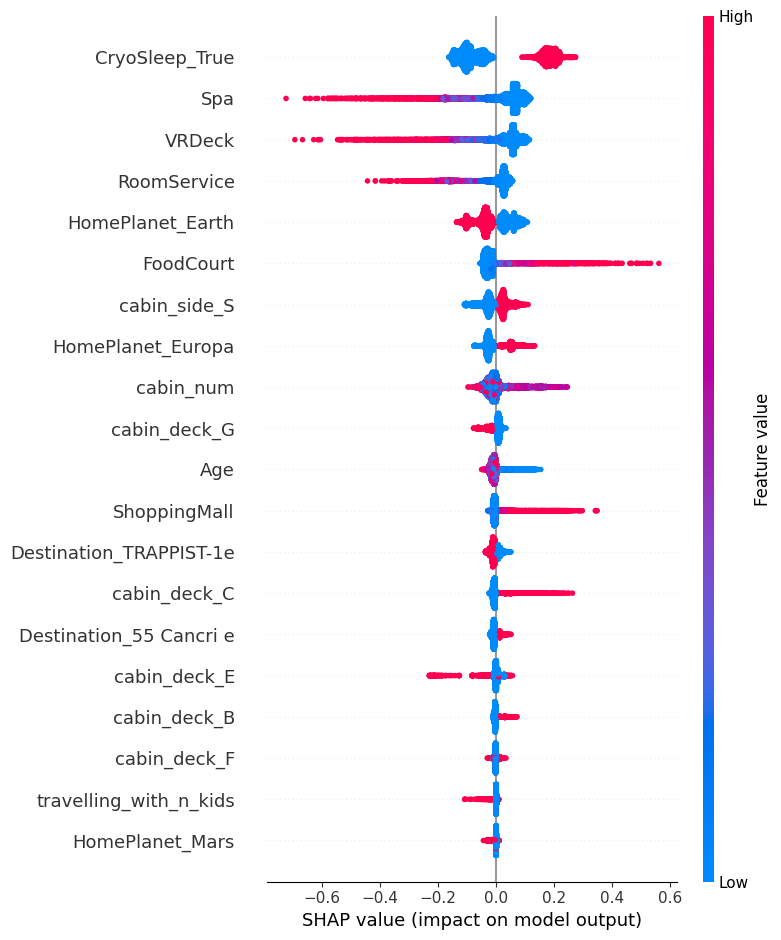

In [15]:
shap.summary_plot(shap_values, train_X)

* 1. Passengers, who chose to spend their travel in Cryosleep, much more likely were transported to another dimention.
* 2. Passengers, who spent a lot of money on spa, VRDeck and room service, most likely weren't transported.
* 3. Passengers, who spent a lot of money at the food court or shopping mall, are more prone to transportation.
* 4. Passengers from Earth are less likely to be transported, whereas passengers from Europe are in more danger.
* 5. People, who were staying on deck E or/and Port side, were in less danger than those who lived on deck C or/and Starboard side.
* 6. Young people were a little more likely to be transported.

Although LIME interpretations contradict with SHAP ones when it comes to spa, room service and home planet Earth. In some cases those features increase score, in others - they decrease it. According to LIME, even Cryosleep can drastically decrease score, which doesn't make sense. I would rely more on SHAP interpretation.

In [24]:
from eli5 import show_weights, explain_prediction
show_weights(xgb_clf, top=5)

In [37]:
explain_prediction(xgb_clf, train_X.iloc[6])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=64, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=1.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='FoodCourt', weight=0.6477628433105607, std=None, value=1539.0), FeatureWeight(feature='VRDeck', weight=0.5489736577365035, std=None, value=0.0), FeatureWeight(feature='Spa', weight=0.3604151266119666, std=None, value=0.0), FeatureWeight(feature='RoomService', weight=0.3483437627264158, std=None, value=42.0), FeatureWeight(feature='cabin_side_S', weight=0.17317408490676817, std=None, value=1.0), FeatureWeight(feature='cabin_deck_G', weight=0.0391722454719869, std=None, value=0.0), FeatureWeight(feature='<BIAS>', weight=0.019130435946518972, std=None, value=1.0), FeatureWeight(feature='travel_group_n', weight=0.01394060626895191, std=None, value=2.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.00871753279577412, std=None, value=0.0), FeatureWeight(feature='travelling_with_n_kids', weight=0.007676406091274636, std=None, value=0.0), FeatureWeight(feature='cabin_deck_F', weight=0.0067636059995679725, std=None, value=1.0)], neg=[FeatureWeight(feature='CryoSleep_True', weight=-0.6119750969439668, std=None, value=0.0), FeatureWeight(feature='HomePlanet_Europa', weight=-0.11615473608375615, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=-0.09332140722829063, std=None, value=2.0), FeatureWeight(feature='HomePlanet_Earth', weight=-0.08488826979778627, std=None, value=1.0), FeatureWeight(feature='ShoppingMall', weight=-0.05720164133758986, std=None, value=3.0), FeatureWeight(feature='Age', weight=-0.05003439403683763, std=None, value=26.0), FeatureWeight(feature='cabin_deck_C', weight=-0.045413659367504265, std=None, value=0.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=-0.025359709524081765, std=None, value=1.0), FeatureWeight(feature='Destination_55 Cancri e', weight=-0.02489901700117221, std=None, value=0.0), FeatureWeight(feature='cabin_deck_B', weight=-0.023704529245303436, std=None, value=0.0)], pos_remaining=0, neg_remaining=0), proba=0.73906565, score=1.0411178473000005, weighted_spans=None, heatmap

In [32]:
explain_prediction(xgb_clf, train_X.iloc[12])

Explanation(estimator="XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=0.9, early_stopping_rounds=None,\n              enable_categorical=False, eta=0.1, eval_metric='error',\n              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,\n              importance_type=None, interaction_constraints=None,\n              learning_rate=None, max_bin=None, max_cat_threshold=None,\n              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,\n              max_leaves=0, min_child_weight=1, missing=nan,\n              monotone_constraints=None, n_estimators=64, n_jobs=None,\n              nthread=4, num_parallel_tree=None, ...)", description='\nFeatures with largest coefficients.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does not show how increasing or\n   decreasing the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0.0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='CryoSleep_True', weight=0.6582188226082102, std=None, value=0.0), FeatureWeight(feature='cabin_side_S', weight=0.1818448611151074, std=None, value=0.0), FeatureWeight(feature='FoodCourt', weight=0.18052108363509176, std=None, value=0.0), FeatureWeight(feature='cabin_num', weight=0.13633247539247462, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Europa', weight=0.1027871229686712, std=None, value=0.0), FeatureWeight(feature='Age', weight=0.07659834030026955, std=None, value=32.0), FeatureWeight(feature='Destination_TRAPPIST-1e', weight=0.0368240714504565, std=None, value=1.0), FeatureWeight(feature='HomePlanet_Mars', weight=0.02236646418425063, std=None, value=1.0), FeatureWeight(feature='cabin_deck_C', weight=0.018371891202557458, std=None, value=0.0), FeatureWeight(feature='Destination_55 Cancri e', weight=0.01661326037602854, std=None, value=0.0), FeatureWeight(feature='VRDeck', weight=0.009515879184160463, std=None, value=113.0), FeatureWeight(feature='cabin_deck_B', weight=0.003924663135835905, std=None, value=0.0)], neg=[FeatureWeight(feature='Spa', weight=-0.34202598566668135, std=None, value=0.0), FeatureWeight(feature='RoomService', weight=-0.3013789610195517, std=None, value=73.0), FeatureWeight(feature='ShoppingMall', weight=-0.21059523592561052, std=None, value=1123.0), FeatureWeight(feature='HomePlanet_Earth', weight=-0.2027952036746749, std=None, value=0.0), FeatureWeight(feature='cabin_deck_E', weight=-0.09393218364625185, std=None, value=0.0), FeatureWeight(feature='cabin_deck_F', weight=-0.04185273537767617, std=None, value=1.0), FeatureWeight(feature='<BIAS>', weight=-0.019130435946518972, std=None, value=1.0), FeatureWeight(feature='cabin_deck_G', weight=-0.009816312224647919, std=None, value=0.0), FeatureWeight(feature='travel_group_n', weight=-0.009561768417897264, std=None, value=1.0), FeatureWeight(feature='travelling_with_n_kids', weight=-0.007676406091274636, std=None, value=0.0), FeatureWeight(feat